In [18]:
# Install the required libraries quietly (-q = quiet mode):
# flwr       - The Flower framework used for federated learning interfaces.
# torch      - The PyTorch deep learning library (models, tensors, autograd).
# torchvision - Official PyTorch extension providing datasets like EuroSAT.
# matplotlib - Library used for plotting images and visualization.
!pip install flwr torch torchvision matplotlib -q

In [3]:
# Flower framework for federated learning abstractions such as NumPyClient.
import flwr as fl

# PyTorch core library: tensor operations, neural networks, autograd engine.
import torch
import torch.nn as nn            # Neural network layers and loss functions.
import torch.optim as optim      # Optimizers such as SGD and Adam.

# Torchvision: provides datasets, transforms, and image-related utilities.
from torchvision import datasets, transforms

# PyTorch utilities for batching and creating dataset subsets.
from torch.utils.data import DataLoader, Subset

# NumPy for numerical operations and handling array-based data splits.
import numpy as np

# Python's built-in random module for reproducible client/cluster assignments.
import random

# Matplotlib for plotting sample satellite images from EuroSAT.
import matplotlib.pyplot as plt


In [4]:
# Set a fixed random seed for full reproducibility across the tutorial.
SEED = 42

# Fix the seed for Python's built-in random module.
# This ensures consistent random cluster assignments and client ordering.
random.seed(SEED)

# Fix the NumPy random seed.
# This ensures that dataset shuffling and splits are deterministic.
np.random.seed(SEED)

# Fix the PyTorch random seed.
# This ensures identical model initialization and training behavior across runs.
torch.manual_seed(SEED)



In [5]:
# EuroSAT images are 64×64 RGB. We define a basic transform that converts
# each PIL image into a PyTorch tensor while preserving channel ordering (C×H×W).
transform = transforms.Compose([
    transforms.ToTensor(),     # Convert image to a float tensor in [0, 1]
])

# Directory where EuroSAT will be stored or downloaded to.
data_root = "./data"

# Load the full EuroSAT training dataset.
# - root: storage location
# - download=True: fetch the dataset if not already present
# - transform: apply the ToTensor() preprocessing step
full_dataset = datasets.EuroSAT(
    root=data_root,
    download=True,
    transform=transform,
)

# Print two things:
# (1) Total number of images in the dataset.
# (2) The shape of the first image tensor, expected to be (3, 64, 64).
len(full_dataset), full_dataset[0][0].shape



100%|██████████| 94.3M/94.3M [00:00<00:00, 241MB/s]


(27000, torch.Size([3, 64, 64]))

In [6]:
# Get the total number of samples in EuroSAT.
num_samples = len(full_dataset)

# Create a list of sample indices: [0, 1, 2, ..., num_samples-1].
indices = np.arange(num_samples)

# Shuffle the indices to ensure random distribution between train/test sets.
np.random.shuffle(indices)

# Define an 80/20 split ratio.
train_size = int(0.8 * num_samples)

# First 80% for training.
train_indices = indices[:train_size]

# Remaining 20% for testing.
test_indices = indices[train_size:]

# Create PyTorch Subset objects for train and test splits.
# Subset allows efficient slicing of datasets without copying any data.
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# Print the number of training and testing samples to confirm the split.
len(train_dataset), len(test_dataset)



(21600, 5400)

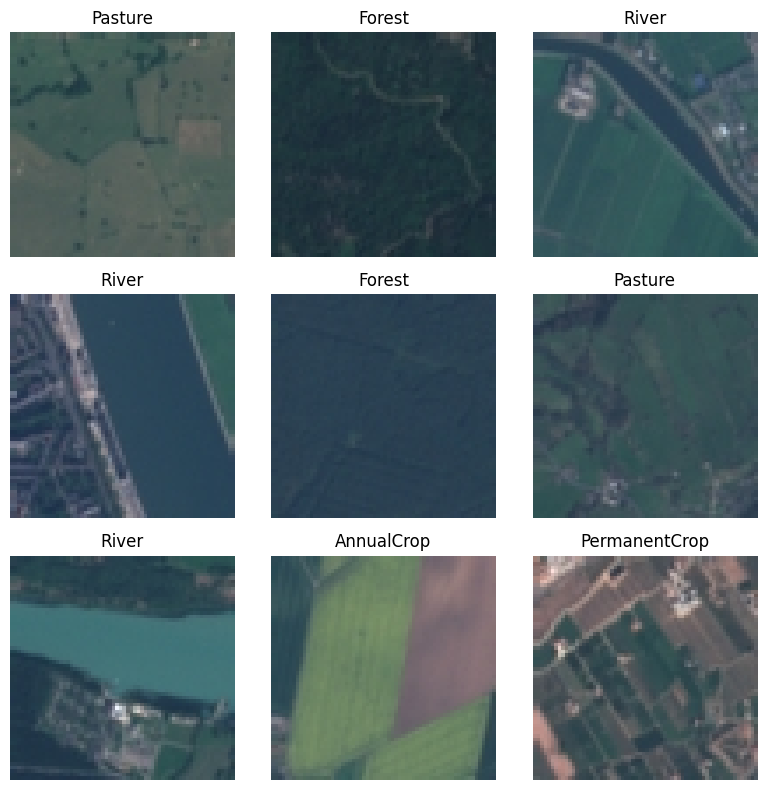

In [8]:
# Display a grid of sample images from the training dataset.
# This helps visualize the EuroSAT dataset, which contains 64×64 RGB satellite images.
def show_samples(dataset, num_images=9):
    # Create a DataLoader that fetches exactly 'num_images' samples in one batch.
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)

    # Extract a batch of images and labels.
    images, labels = next(iter(loader))

    # Keep only 'num_images' samples (safety in case the dataset is smaller).
    images = images[:num_images]
    labels = labels[:num_images]

    # Retrieve EuroSAT class names (e.g., Forest, River, Residential, etc.)
    class_names = full_dataset.classes

    # Create a 3×3 visualization grid.
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        # Use subplot to position each image.
        plt.subplot(3, 3, i + 1)

        # Images are stored as (C, H, W). We permute them to (H, W, C) for plotting.
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)

        # Show the corresponding land-use class label.
        plt.title(class_names[labels[i]])

        # Hide axis ticks for a cleaner presentation.
        plt.axis("off")

    # Adjust spacing to prevent label/image overlap.
    plt.tight_layout()
    plt.show()

# Call the function to display sample images from the training set.
show_samples(train_dataset)



In [9]:
# Number of federated clients (simulated satellites).
num_clients = 50

# Convert the training indices into a NumPy array for shuffling.
train_indices_array = np.array(train_indices)

# Shuffle the indices to ensure each client receives a random subset.
np.random.shuffle(train_indices_array)

# Split the shuffled indices into 50 uneven parts.
# np.array_split automatically divides the array into nearly equal chunks,
# but because the dataset size is not guaranteed to be divisible by 50,
# some clients will receive slightly more or fewer samples.
client_indices_list = np.array_split(train_indices_array, num_clients)

# Create a PyTorch Subset for each client dataset.
# Each Subset object contains only the image indices assigned to that client.
client_datasets = [
    Subset(full_dataset, inds) for inds in client_indices_list
]

# Display the sample sizes of the first five clients to verify heterogeneity.
[len(ds) for ds in client_datasets[:5]]



[432, 432, 432, 432, 432]

In [10]:
# Number of clusters in the hierarchical FL system.
# Each cluster simulates a group of satellites that can communicate efficiently via ISLs.
num_clusters = 5

# Initialize an empty list for each cluster.
# cluster_assignments[c] will hold the client IDs assigned to cluster c.
cluster_assignments = [[] for _ in range(num_clusters)]

# List all client IDs (0 to 49) and shuffle them randomly
# to ensure that clusters receive a random mixture of clients.
client_ids = list(range(num_clients))
random.shuffle(client_ids)

# Assign clients to clusters in a round-robin manner.
# Example: after shuffling, clients are assigned in order:
# cluster 0 gets client_ids[0], cluster 1 gets client_ids[1], ..., cluster 4 gets client_ids[4],
# then again cluster 0 gets client_ids[5], and so on.
for idx, cid in enumerate(client_ids):
    cluster_id = idx % num_clusters
    cluster_assignments[cluster_id].append(cid)

# For each cluster, select one master satellite.
# The master acts as the cluster-level aggregator during hierarchical FL.
cluster_masters = {
    c: random.choice(cluster_assignments[c]) for c in range(num_clusters)
}

# Print cluster compositions for inspection.
print("Cluster assignments (client IDs):")
for c in range(num_clusters):
    print(f"Cluster {c}: {cluster_assignments[c]}")

# Print which client serves as the master satellite for each cluster.
print("\nCluster masters:")
for c in range(num_clusters):
    print(f"Cluster {c} master: client {cluster_masters[c]}")


Cluster assignments (client IDs):
Cluster 0: [25, 45, 31, 38, 43, 30, 46, 49, 5, 15]
Cluster 1: [23, 26, 21, 10, 18, 28, 36, 47, 34, 17]
Cluster 2: [19, 9, 12, 24, 33, 20, 32, 2, 6, 1]
Cluster 3: [11, 29, 3, 35, 48, 22, 44, 27, 8, 7]
Cluster 4: [4, 16, 39, 0, 41, 42, 13, 37, 14, 40]

Cluster masters:
Cluster 0 master: client 5
Cluster 1 master: client 26
Cluster 2 master: client 32
Cluster 3 master: client 29
Cluster 4 master: client 14


In [11]:
# Define a lightweight CNN tailored for EuroSAT image classification.
# The model is intentionally small to resemble low-power computation on satellites.
class SimpleEuroSATCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Convolutional feature extractor:
        # Input: 3×64×64 RGB images
        # Conv + ReLU + MaxPool progressively reduces spatial resolution
        # while increasing the number of feature channels.
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Output: 16×64×64
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: 16×32×32

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # Output: 32×32×32
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: 32×16×16

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Output: 64×16×16
            nn.ReLU(),
            nn.MaxPool2d(2),                             # Output: 64×8×8
        )

        # Fully connected classifier:
        # Takes flattened 64×8×8 features and maps them to class logits.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),                  # Hidden layer
            nn.ReLU(),
            nn.Linear(128, num_classes),                 # Output: class scores
        )

    def forward(self, x):
        # Pass input image through feature extractor and classifier.
        x = self.features(x)
        x = self.classifier(x)
        return x

# Determine number of EuroSAT land-use classes (typically 10).
num_classes = len(full_dataset.classes)

# Create the initial global model to be distributed to all clients.
global_model = SimpleEuroSATCNN(num_classes=num_classes)

# Select computation device (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the global model to the chosen device.
global_model.to(device)

# Display number of classes (for confirmation).
num_classes


10

In [12]:
# Define a federated learning client representing one satellite.
# The class follows the Flower NumPyClient interface style but operates locally.
class SatelliteClient(fl.client.NumPyClient):
    def __init__(self, cid, dataset, device):
        # cid: client ID (0 to 49)
        # dataset: the local subset of EuroSAT assigned to this client
        # device: CPU or GPU for computation
        self.cid = cid
        self.dataset = dataset
        self.device = device

        # Each client maintains its own private model instance.
        self.model = SimpleEuroSATCNN(num_classes=num_classes).to(self.device)

        # Use cross-entropy loss for multi-class classification.
        self.loss_fn = nn.CrossEntropyLoss()

    # ----------------------------------------------------------
    # Convert PyTorch model parameters to NumPy arrays.
    # This format is used for exchange during FL aggregation.
    # ----------------------------------------------------------
    def get_parameters_numpy(self):
        return [p.detach().cpu().numpy() for p in self.model.state_dict().values()]

    # ----------------------------------------------------------
    # Load a list of NumPy arrays into the model's state dict.
    # Allows applying global/cluster parameters to the client model.
    # ----------------------------------------------------------
    def set_parameters_numpy(self, parameters):
        state_dict = self.model.state_dict()
        new_state_dict = {}

        # Zip together state_dict keys and incoming NumPy tensors.
        for (k, v), np_val in zip(state_dict.items(), parameters):
            new_state_dict[k] = torch.tensor(np_val, dtype=v.dtype)

        # Update the model with converted parameters.
        self.model.load_state_dict(new_state_dict, strict=True)

    # ----------------------------------------------------------
    # Local training (one client performing local SGD).
    # Returns:
    #   - updated model parameters (NumPy format)
    #   - number of samples used for training
    #   - average training loss
    # ----------------------------------------------------------
    def fit_local(self, global_params, epochs=1, batch_size=32, lr=0.001):
        # Load the latest global (or cluster-level) parameters.
        self.set_parameters_numpy(global_params)

        # Create a DataLoader for local data.
        loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)

        # Adam optimizer for local updates.
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.model.train()
        total_loss = 0.0
        total_samples = 0

        # Perform local SGD for the given number of epochs.
        for _ in range(epochs):
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                preds = self.model(x)
                loss = self.loss_fn(preds, y)
                loss.backward()
                optimizer.step()

                # Accumulate loss statistics.
                bs = y.size(0)
                total_loss += loss.item() * bs
                total_samples += bs

        # Compute mean loss over all local samples.
        avg_train_loss = total_loss / total_samples if total_samples > 0 else 0.0

        # Return updated parameters, number of samples, and avg loss.
        return self.get_parameters_numpy(), len(self.dataset), avg_train_loss

    # ----------------------------------------------------------
    # Optional helper to evaluate the client model on its own data.
    # Returns classification accuracy.
    # ----------------------------------------------------------
    def evaluate_local(self, params, batch_size=64):
        # Load the incoming parameters (global/cluster-level).
        self.set_parameters_numpy(params)

        loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=False)
        self.model.eval()
        correct, total = 0, 0

        # Inference with no gradient computation.
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                preds = self.model(x)
                _, predicted = torch.max(preds, dim=1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        # Return accuracy (0 to 1).
        return correct / total if total > 0 else 0.0



In [13]:
# Create a list of all satellite clients.
# Each client receives:
#   - a unique client ID (0 to num_clients-1),
#   - its own local dataset (one of the 50 partitions),
#   - a computation device (CPU or GPU).
#
# This constructs the full set of federated learning clients that will
# participate in training inside each cluster.
clients = [
    SatelliteClient(cid=i, dataset=client_datasets[i], device=device)
    for i in range(num_clients)
]



In [14]:
def weighted_average_params(param_list, weights):
    """Compute weighted average of a list of parameter lists.

    Args:
        param_list: List of model parameter sets.
                    Each element is itself a list of tensors (one tensor per layer).
        weights: List of integers or floats representing the number
                 of samples used by each client during training.

    Returns:
        avg_params: A list of tensors representing the weighted average
                    of all input parameter sets.
    """
    # Compute the sum of all client weights (total number of samples).
    total_weight = sum(weights)

    # Initialize the list to store averaged parameters.
    avg_params = []

    # Loop through each model parameter index (e.g., layer weights/biases).
    for params_idx in range(len(param_list[0])):

        # Compute the weighted sum for the current parameter across clients.
        weighted_sum = sum(
            param_list[cid][params_idx] * (weights[cid] / total_weight)
            for cid in range(len(param_list))
        )

        # Append the averaged result for this parameter.
        avg_params.append(weighted_sum)

    return avg_params


def fedavg(results):
    """Perform FedAvg on a list of training results.

    Args:
        results: A list of tuples formatted as:
                 (params, num_samples)
                 where params is a list of tensors and num_samples is the weight.

    Returns:
        Weighted average of all params using num_samples as weights.
    """
    # Extract the parameter list for all clients/clusters.
    param_list = [r[0] for r in results]

    # Extract the number of samples (weights).
    weights = [r[1] for r in results]

    # Return the weighted average.
    return weighted_average_params(param_list, weights)


In [15]:
# Create a DataLoader for evaluating model performance on the global test set.
# - batch_size=64 provides a good balance between speed and memory usage.
# - shuffle=False ensures deterministic evaluation.
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


def evaluate_params_on_test(params):
    """Evaluate a given set of model parameters on the global test dataset.

    Args:
        params: A list of NumPy arrays representing model weights.

    Returns:
        avg_loss (float): Average cross-entropy loss over the entire test set.
        acc (float): Classification accuracy (correct / total) on the test set.
    """

    # --------------------------------------------------------------
    # Step 1: Load incoming parameters into the global model.
    # --------------------------------------------------------------
    state_dict = global_model.state_dict()
    new_state = {}

    # Convert each NumPy parameter into a PyTorch tensor
    # while preserving the corresponding dtype.
    for (k, v), np_val in zip(state_dict.items(), params):
        new_state[k] = torch.tensor(np_val, dtype=v.dtype)

    # Replace the model's weights.
    global_model.load_state_dict(new_state, strict=True)

    # Put the model in evaluation mode (disables dropout, BN updates).
    global_model.eval()

    # Loss function for evaluating classification performance.
    loss_fn = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_samples = 0
    correct = 0

    # --------------------------------------------------------------
    # Step 2: Loop through the test set and compute metrics.
    # --------------------------------------------------------------
    with torch.no_grad():  # Disable gradient calculations for speed.
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            # Forward pass
            preds = global_model(x)

            # Compute batch loss
            loss = loss_fn(preds, y)

            # Update cumulative loss and sample count
            bs = y.size(0)
            total_loss += loss.item() * bs
            total_samples += bs

            # Compute batch accuracy
            _, predicted = torch.max(preds, dim=1)
            correct += (predicted == y).sum().item()

    # --------------------------------------------------------------
    # Step 3: Compute aggregated performance metrics.
    # --------------------------------------------------------------
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    acc = correct / total_samples if total_samples > 0 else 0.0

    return avg_loss, acc



In [17]:
# Initialize global parameters from a fresh global model instance.
global_model = SimpleEuroSATCNN(num_classes=num_classes).to(device)
initial_state = global_model.state_dict()

# Convert the initial PyTorch parameters to a list of NumPy arrays.
# These serve as the starting global parameters for all clients.
global_params = [v.detach().cpu().numpy() for v in initial_state.values()]

# Federated learning hyperparameters.
num_global_rounds = 2          # Number of global rounds (GS <-> clusters)
num_cluster_rounds = 2         # Number of internal rounds within each cluster per global round
local_epochs = 1               # Number of local training epochs per client per call
local_batch_size = 64          # Local batch size for client training
local_lr = 0.001               # Local learning rate for client optimizers

# Main hierarchical federated learning loop.
for rnd in range(1, num_global_rounds + 1):
    print(f"\n========== Global Round {rnd} ==========")

    # List to collect the final parameters and weights from each cluster master.
    # Each entry: (cluster_params, total_samples_in_cluster)
    cluster_master_results = []

    # ----------------------------------------------------------
    # Cluster-level training and aggregation
    # ----------------------------------------------------------
    for c in range(num_clusters):
        client_ids_in_cluster = cluster_assignments[c]
        print(f"\n[Cluster {c}] Clients: {client_ids_in_cluster}")

        # At the beginning of each global round, the initial cluster model
        # is set to the current global model.
        cluster_params = global_params
        cluster_total_samples = 0

        # Keep track of the last cluster-level test metrics for reporting.
        last_cluster_test_loss, last_cluster_test_acc = None, None

        # ------------------------------------------------------
        # Multiple internal rounds within the cluster
        # ------------------------------------------------------
        for cr in range(1, num_cluster_rounds + 1):
            print(f"  [Cluster {c}] Internal round {cr}/{num_cluster_rounds}")

            # Accumulate client updates for this internal round.
            # cluster_results: list of (params, num_samples)
            cluster_results = []
            # Optional: store each client's training loss for inspection.
            cluster_train_losses = []

            # Each client in the cluster performs local training
            # starting from the current cluster parameters.
            for cid in client_ids_in_cluster:
                client = clients[cid]
                updated_params, num_samples, train_loss = client.fit_local(
                    cluster_params,
                    epochs=local_epochs,
                    batch_size=local_batch_size,
                    lr=local_lr,
                )
                cluster_results.append((updated_params, num_samples))
                cluster_train_losses.append(train_loss)
                cluster_total_samples += num_samples

                print(
                    f"    Client {cid} finished local training on "
                    f"{num_samples} samples, avg train loss = {train_loss:.4f}"
                )

            # Perform FedAvg within the cluster for this internal round.
            # The result becomes the new cluster model (master model).
            cluster_params = fedavg(cluster_results)

            # Evaluate the current cluster master model on the global test set.
            cluster_test_loss, cluster_test_acc = evaluate_params_on_test(cluster_params)
            last_cluster_test_loss, last_cluster_test_acc = cluster_test_loss, cluster_test_acc

            print(
                f"  [Cluster {c}] After internal round {cr}, "
                f"master test loss = {cluster_test_loss:.4f}, "
                f"test acc = {cluster_test_acc:.4f}"
            )

        # After all internal rounds, 'cluster_params' is the final master model
        # that will be uploaded to the Ground Station (GS).
        cluster_master_results.append((cluster_params, cluster_total_samples))

        print(
            f"[Cluster {c}] Finished all {num_cluster_rounds} internal rounds, "
            f"total samples = {cluster_total_samples}."
        )
        print(
            f"[Cluster {c}] Final master test loss = {last_cluster_test_loss:.4f}, "
            f"test acc = {last_cluster_test_acc:.4f}"
        )

    # ----------------------------------------------------------
    # Ground Station aggregation across all cluster masters
    # ----------------------------------------------------------
    # Perform FedAvg over all cluster master models to obtain updated global_params.
    global_params = fedavg(cluster_master_results)
    print("\n[GS] Aggregated models from all cluster masters.")

    # ----------------------------------------------------------
    # Evaluation at the Ground Station (global model)
    # ----------------------------------------------------------
    gs_test_loss, gs_test_acc = evaluate_params_on_test(global_params)
    print(f"[GS] Global model test loss after round {rnd}:  {gs_test_loss:.4f}")
    print(f"[GS] Global model test accuracy after round {rnd}: {gs_test_acc:.4f}")



========== Global Round 1 ==========

[Cluster 0] Clients: [25, 45, 31, 38, 43, 30, 46, 49, 5, 15]
  [Cluster 0] Internal round 1/2
    Client 25 finished local training on 432 samples, avg train loss = 2.2895
    Client 45 finished local training on 432 samples, avg train loss = 2.2919
    Client 31 finished local training on 432 samples, avg train loss = 2.2811
    Client 38 finished local training on 432 samples, avg train loss = 2.2948
    Client 43 finished local training on 432 samples, avg train loss = 2.2928
    Client 30 finished local training on 432 samples, avg train loss = 2.2918
    Client 46 finished local training on 432 samples, avg train loss = 2.2845
    Client 49 finished local training on 432 samples, avg train loss = 2.2911
    Client 5 finished local training on 432 samples, avg train loss = 2.2832
    Client 15 finished local training on 432 samples, avg train loss = 2.2847
  [Cluster 0] After internal round 1, master test loss = 2.2459, test acc = 0.1569
  [Cl